In [1]:
from prepare_data_generator import prepare_data

import random
seed = 32
validation_split = 0.2

def shuffle_and_split(data, validation_split, seed):
    import random
    random.seed(seed)
    random.shuffle(data)
    random.seed()
    split = int(len(data)*(1-validation_split))
    return data[:split], data[split:]

face_landmarks_dict = {'train': {}, 'val': {}}
face_landmarks_final = {'train': [], 'val': []}
# load muct clm data through https://github.com/azhongwl/clmtools; around 600 faces, ~100 in the wild of varying poses
landmarks = prepare_data('/data/muct_clmtools/images/',
                         '/data/muct_clmtools/annotations.csv',
                         'muct_clmtools')
face_landmarks_dict['train']['muct_clmtools'], face_landmarks_dict['val']['muct_clmtools'] = shuffle_and_split(
    landmarks, validation_split, seed)
for train_val in ['train', 'val']:
    for key in face_landmarks_dict[train_val].keys():
        face_landmarks_final[train_val].extend(face_landmarks_dict[train_val][key])
for train_val in ['train', 'val']:
    for fl in face_landmarks_final[train_val]:
        fl.convert_to_landmark_type('muct')
print(len(face_landmarks_final['train']), len(face_landmarks_final['val']))

408 103


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import datetime
import os
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau


from generator import ImageFaceLandmarkDataGenerator
from muct import MUCT

def preprocess_image(image):
    image = image / 255.0
    image = image - 0.5
    image = image * 2.0
    return image


train_data_gen = ImageFaceLandmarkDataGenerator(rotate_bounding_box_part='face',
                                                rotate_limit_in_degrees=10,
                                                scale_bounding_box_part='face',
                                                scale_bounding_box_size=64,
                                                scale_limit_ratio=0.1,
                                                translate_x_ratio=0.2,
                                                translate_y_ratio=0.3,
                                                target_bounding_box_part='mouth',
                                                preprocessing_function=preprocess_image)
val_data_gen = ImageFaceLandmarkDataGenerator(rotate_bounding_box_part='face',
                                              scale_bounding_box_part='face',
                                              scale_bounding_box_size=64,
                                              target_bounding_box_part='mouth',
                                              preprocessing_function=preprocess_image)
                                              
batch_size = 32
input_shape = (32, 32, 3)
topic = 'mouth_12'
output_size = int(topic.split('_')[-1])
num_epochs = 1000
patience = 50

now = datetime.datetime.now()
model_name = 'kao_onet_{}_lm_{}'.format(input_shape[0], output_size)

base_path = 'models/' + model_name + '_'
base_path += now.strftime("%Y_%m_%d_%H_%M_%S") + '/'
if not os.path.exists(base_path):
    os.makedirs(base_path)

from models import Kao_Onet
model = Kao_Onet(input_shape, output_size)
model.compile(loss='mse', optimizer = 'adam', metrics=['mse'])

log_file_path = base_path + 'faceoff_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=int(patience/4), verbose=1)
trained_models_path = base_path + 'faceoff_' + model_name
model_names = trained_models_path + '.{epoch:02d}-{val_loss:.2f}-{loss:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                   save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]


model.fit_generator(train_data_gen.flow(face_landmarks_final['train'], MUCT[topic], (32, 32), batch_size),
                    steps_per_epoch = 3,
                    epochs = num_epochs,
                    callbacks = callbacks,
                    verbose = 1,
                    validation_data = val_data_gen.flow(face_landmarks_final['val'], MUCT[topic], (32, 32), batch_size))


/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/1000
3/3 [==============================] - 2s 578ms/step - loss: 307.0926 - mean_squared_error: 307.0926 - val_loss: 277.8309 - val_mean_squared_error: 277.8309

Epoch 00001: val_loss improved from inf to 277.83094, saving model to models/kao_onet_32_lm_12_2018_07_31_14_45_35/faceoff_kao_onet_32_lm_12.01-277.83-307.09.hdf5
Epoch 2/1000
3/3 [==============================] - 1s 346ms/step - loss: 292.8306 - mean_squared_error: 292.8306 - val_loss: 246.3484 - val_mean_squared_error: 246.3484

Epoch 00002: val_loss improved from 277.83094 to 246.34844, saving model to models/kao_onet_32_lm_12_2018_07_31_14_45_35/faceoff_kao_onet_32_lm_12.02-246.35-292.83.hdf5
Epoch 3/1000
3/3 [==============================] - 1s 344ms/step - loss: 243.9644 - mean_squared_error: 243.9644 - val_loss: 156.0134 - val_mean_squared_error: 156.0134

Epoch 00003: val_loss improved from 246.34844 to 156.01339, saving model to models/kao_onet_32_lm_12_2018_07_31_14_45_35/faceoff_kao_onet_32_lm_12.03-156.0

KeyboardInterrupt: 

94 211 255 447
12


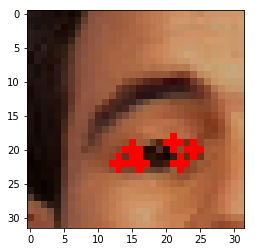

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import datetime
import os

from generator import ImageFaceLandmarkDataGenerator
from muct import MUCT

batch_size = 1
input_shape = (32, 32, 3)
topic = 'left_eye_12'
output_size = int(topic.split('_')[-1])

test_generator = ImageFaceLandmarkDataGenerator(rotate_bounding_box_part='face',
                                                rotate_limit_in_degrees=10,
                                                scale_bounding_box_part='face',
                                                scale_bounding_box_size=64,
                                                scale_limit_ratio=0.1,
                                                translate_x_ratio=0.2,
                                                translate_y_ratio=0.3,
                                                target_bounding_box_part='left_eye',
                                                random_horizontal_flip=True)

for X, y in test_generator.flow(face_landmarks_final['train'], MUCT[topic], (32, 32), batch_size):
    bgr_image = X[0]
    landmarks = y[0]
    print(len(landmarks))
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    for i in range(0, len(landmarks), 2):
        cv2.circle(rgb_image, (int(landmarks[i]), int(landmarks[i+1])), 1, (255), -1)
    plt.imshow(rgb_image)
    plt.show()
    break